In [1]:
# ====================================================================
# ULTRA-ENRICHED STATISTICAL ANALYSIS
# DNA Gene Mapping Project - 100+ Features
# Author: Sharique Mohammad
# Date: 14 January 2026
# ====================================================================
# jupyter_notebooks/05_statistical_analysis_ULTRA_ENRICHED.ipynb
# ====================================================================

In [2]:
# Import necessary libraries

import pandas as pd
import numpy as np
import psycopg2
from sqlalchemy import create_engine
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os
from pathlib import Path
import warnings

In [3]:
# Suppress warnings for cleaner output

warnings.filterwarnings('ignore')
load_dotenv()

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print('Libraries imported successfully')

Libraries imported successfully


In [4]:
# Setup Paths

PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'jupyter_notebooks' else Path.cwd()
ANALYTICAL_DIR = PROJECT_ROOT / 'data' / 'analytical'
VIZ_DIR = ANALYTICAL_DIR / 'visualizations'

# Create directories if they don't exist
ANALYTICAL_DIR.mkdir(parents=True, exist_ok=True)
VIZ_DIR.mkdir(parents=True, exist_ok=True)

print(f'Project root: {PROJECT_ROOT}')
print(f'Analytical directory: {ANALYTICAL_DIR}')
print(f'Visualizations directory: {VIZ_DIR}')

Project root: C:\Users\Sharique\Desktop\Self_Project\GitHub_Project\genomic-variant-data-science-pipeline
Analytical directory: C:\Users\Sharique\Desktop\Self_Project\GitHub_Project\genomic-variant-data-science-pipeline\data\analytical
Visualizations directory: C:\Users\Sharique\Desktop\Self_Project\GitHub_Project\genomic-variant-data-science-pipeline\data\analytical\visualizations


In [5]:
# Database Connection

DB_CONFIG = {
    'host': os.getenv('POSTGRES_HOST', 'localhost'),
    'port': int(os.getenv('POSTGRES_PORT', 5432)),
    'database': os.getenv('POSTGRES_DATABASE', 'genome_db'),
    'user': os.getenv('POSTGRES_USER', 'postgres'),
    'password': os.getenv('POSTGRES_PASSWORD')
}

engine = create_engine(
    f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}"
    f"@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
)

conn = psycopg2.connect(
    host=DB_CONFIG['host'],
    database=DB_CONFIG['database'],
    user=DB_CONFIG['user'],
    password=DB_CONFIG['password']
)

print('Database connection established')

Database connection established


In [6]:
# Load Ultra-Enriched Data from PostgreSQL

print('Loading ultra-enriched data from PostgreSQL gold layer...')
print('='*70)

df_gene_features = pd.read_sql('SELECT * FROM gold.gene_features', engine)
df_chromosome_features = pd.read_sql('SELECT * FROM gold.chromosome_features', engine)
df_gene_disease = pd.read_sql('SELECT * FROM gold.gene_disease_association', engine)
df_ml_features = pd.read_sql('SELECT * FROM gold.ml_features', engine)

print(f'\nLoaded {len(df_gene_features):,} genes with {len(df_gene_features.columns)} columns')
print(f'Loaded {len(df_chromosome_features)} chromosomes with {len(df_chromosome_features.columns)} columns')
print(f'Loaded {len(df_gene_disease):,} gene-disease associations with {len(df_gene_disease.columns)} columns')
print(f'Loaded {len(df_ml_features):,} ML features with {len(df_ml_features.columns)} columns')

print('\n' + '='*70)
print('ULTRA-ENRICHED DATA LOADED SUCCESSFULLY')
print('='*70)

Loading ultra-enriched data from PostgreSQL gold layer...

Loaded 28,165 genes with 105 columns
Loaded 25 chromosomes with 20 columns
Loaded 267,367 gene-disease associations with 25 columns
Loaded 28,165 ML features with 100 columns

ULTRA-ENRICHED DATA LOADED SUCCESSFULLY


In [7]:
# Ultra-Enriched Features Overview

print('\nULTRA-ENRICHED FEATURES OVERVIEW')
print('='*70)

# Define feature categories
protein_types = ['is_kinase', 'is_phosphatase', 'is_receptor', 'is_gpcr',
                 'is_transcription_factor', 'is_enzyme', 'is_transporter',
                 'is_channel', 'is_membrane_protein', 'is_growth_factor',
                 'is_structural', 'is_regulatory', 'is_metabolic',
                 'is_dna_binding', 'is_rna_binding', 'is_ubiquitin_related', 'is_protease']

disease_categories = ['cancer_related', 'immune_related', 'neurological_related',
                     'cardiovascular_related', 'metabolic_related', 'developmental_related',
                     'alzheimer_related', 'diabetes_related', 'breast_cancer_related']

cellular_locations = ['nuclear', 'mitochondrial', 'cytoplasmic', 'membrane',
                     'extracellular', 'endoplasmic_reticulum', 'golgi',
                     'lysosomal', 'peroxisomal']

clinical_scores = ['avg_clinical_actionability', 'avg_clinical_utility', 
                  'avg_mutation_severity', 'druggability_score', 'avg_review_quality']

mutation_types = ['frameshift_count', 'nonsense_count', 'splice_count', 'missense_count',
                 'deletion_count', 'insertion_count', 'duplication_count', 'indel_count']

inheritance_patterns = ['germline_count', 'somatic_count', 'de_novo_count', 
                       'maternal_count', 'paternal_count']

print(f'\nFeature Categories Available:')
print(f'  - 17 Functional Protein Types: {len(protein_types)} columns')
print(f'  - 9 Disease Categories: {len(disease_categories)} columns')
print(f'  - 9 Cellular Locations: {len(cellular_locations)} columns')
print(f'  - 5 Clinical Scores: {len(clinical_scores)} columns')
print(f'  - 8 Mutation Types: {len(mutation_types)} columns')
print(f'  - 5 Inheritance Patterns: {len(inheritance_patterns)} columns')
print(f'\nTotal New Ultra-Enriched Features: {len(protein_types) + len(disease_categories) + len(cellular_locations) + len(clinical_scores) + len(mutation_types) + len(inheritance_patterns)}')


ULTRA-ENRICHED FEATURES OVERVIEW

Feature Categories Available:
  - 17 Functional Protein Types: 17 columns
  - 9 Disease Categories: 9 columns
  - 9 Cellular Locations: 9 columns
  - 5 Clinical Scores: 5 columns
  - 8 Mutation Types: 8 columns
  - 5 Inheritance Patterns: 5 columns

Total New Ultra-Enriched Features: 53


In [8]:
# Data Cleaning and Preparation

print('\n' + '='*70)
print('DATA CLEANING AND PREPARATION')
print('='*70)

# Remove rows with NULL chromosome
df_clean = df_gene_features[df_gene_features['chromosome'].notna()].copy()
print(f'Removed {len(df_gene_features) - len(df_clean)} genes with NULL chromosome')
print(f'Working with {len(df_clean):,} genes')

# Check pathogenic_ratio
if df_clean['pathogenic_ratio'].sum() == 0:
    print('\nWARNING: All pathogenic_ratio values are 0')
    print('Creating pathogenic_ratio from total_pathogenic/mutation_count')
    df_clean['pathogenic_ratio'] = df_clean['total_pathogenic'] / df_clean['mutation_count']

print(f'\nData ready for analysis')


DATA CLEANING AND PREPARATION
Removed 8057 genes with NULL chromosome
Working with 20,108 genes

Data ready for analysis


In [9]:
# Data Overview

print('\n' + '='*70)
print('ULTRA-ENRICHED GENE FEATURES OVERVIEW')
print('='*70)
print(df_clean.head())
print('\nData Shape:', df_clean.shape)
print('\nData Types (first 20):')
print(df_clean.dtypes.head(20))
print('\nBasic Statistics (key columns):')
key_cols = ['mutation_count', 'pathogenic_ratio', 'druggability_score', 
            'avg_clinical_utility', 'risk_score']
available_key_cols = [col for col in key_cols if col in df_clean.columns]
print(df_clean[available_key_cols].describe())


ULTRA-ENRICHED GENE FEATURES OVERVIEW
  gene_name  mutation_count  pathogenic_count  likely_pathogenic_count  \
0     PGBD3              70                 0                        0   
1    ATP1A2            1469                50                       77   
2      SKA1              28                 0                        0   
3     NPY5R              56                 0                        0   
4      CD1D              53                 0                        0   

   benign_count  likely_benign_count  vus_count  conflicting_count  \
0             0                    4         66                  0   
1           103                  513        640                 82   
2             0                    2         18                  0   
3             0                    6         47                  0   
4             1                    3         46                  0   

   frameshift_count  nonsense_count  ...  cytoplasmic  membrane  \
0                 0         

In [10]:
# Missing Value Analysis

print('\n' + '='*70)
print('MISSING VALUE ANALYSIS')
print('='*70)

missing_data = pd.DataFrame({
    'Column': df_clean.columns,
    'Missing_Count': df_clean.isnull().sum(),
    'Missing_Percentage': (df_clean.isnull().sum() / len(df_clean) * 100).round(2)
})
missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_data) > 0:
    print('\nColumns with missing values (top 20):')
    print(missing_data.head(20))
else:
    print('\nNo missing values found')


MISSING VALUE ANALYSIS

Columns with missing values (top 20):
                            Column  Missing_Count  Missing_Percentage
gene_length            gene_length          20108              100.00
mutation_density  mutation_density          20108              100.00
mim_id                      mim_id           3430               17.06
cyto_band                cyto_band           2361               11.74
avg_aa_position    avg_aa_position           1387                6.90
cyto_arm                  cyto_arm            941                4.68
ensembl_id              ensembl_id            402                2.00
hgnc_id                    hgnc_id            261                1.30
cyto_region            cyto_region            145                0.72



FUNCTIONAL PROTEIN TYPE DISTRIBUTION
Kinase                            919 genes ( 4.57%)
Phosphatase                       544 genes ( 2.71%)
Receptor                        1,972 genes ( 9.81%)
Gpcr                            5,320 genes (26.46%)
Transcription Factor              557 genes ( 2.77%)
Enzyme                          2,372 genes (11.80%)
Transporter                       774 genes ( 3.85%)
Channel                           394 genes ( 1.96%)
Membrane Protein                1,236 genes ( 6.15%)
Growth Factor                     226 genes ( 1.12%)
Structural                      1,370 genes ( 6.81%)
Regulatory                      1,373 genes ( 6.83%)
Metabolic                          34 genes ( 0.17%)
Dna Binding                        93 genes ( 0.46%)
Rna Binding                       250 genes ( 1.24%)
Ubiquitin Related                 535 genes ( 2.66%)
Protease                          539 genes ( 2.68%)

Total unique genes: 20,108
Genes with at least one function:

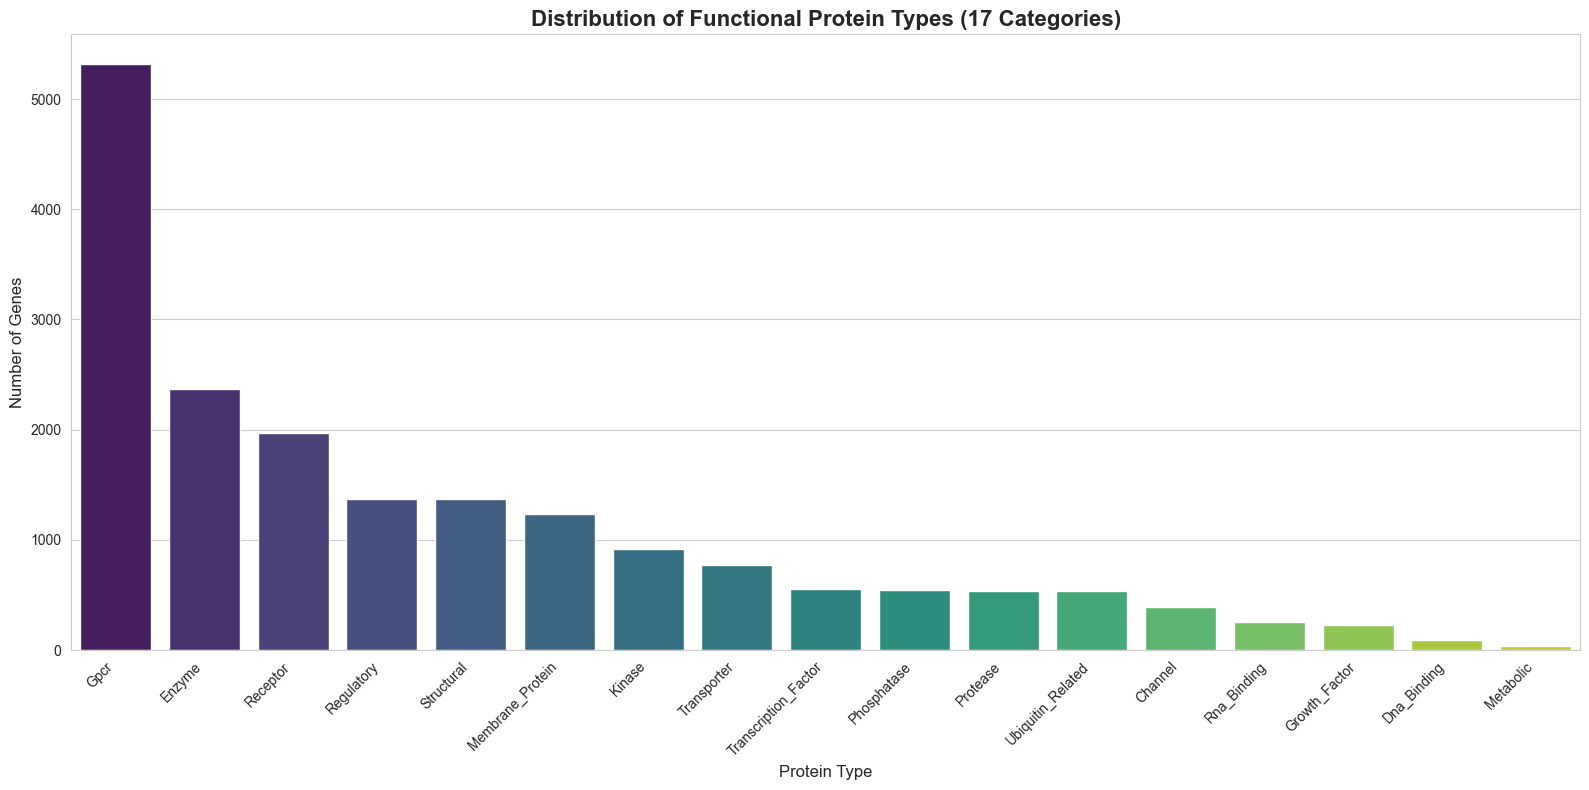


Saved: 01_protein_type_distribution.png


In [11]:
# Functional Protein Type Analysis

print('\n' + '='*70)
print('FUNCTIONAL PROTEIN TYPE DISTRIBUTION')
print('='*70)

protein_counts = {}
for ptype in protein_types:
    if ptype in df_clean.columns:
        count = df_clean[ptype].sum()
        pct = (count / len(df_clean)) * 100
        protein_counts[ptype.replace('is_', '').title()] = count
        print(f"{ptype.replace('is_', '').replace('_', ' ').title():30} {count:6,} genes ({pct:5.2f}%)")

print(f'\nTotal unique genes: {len(df_clean):,}')
genes_with_function = df_clean[[col for col in protein_types if col in df_clean.columns]].any(axis=1).sum()
print(f'Genes with at least one function: {genes_with_function:,} ({genes_with_function/len(df_clean)*100:.2f}%)')

# Visualization
plt.figure(figsize=(16, 8))
protein_df = pd.DataFrame(list(protein_counts.items()), columns=['Protein Type', 'Count'])
protein_df = protein_df.sort_values('Count', ascending=False)
sns.barplot(data=protein_df, x='Protein Type', y='Count', palette='viridis')
plt.title('Distribution of Functional Protein Types (17 Categories)', fontsize=16, fontweight='bold')
plt.xlabel('Protein Type', fontsize=12)
plt.ylabel('Number of Genes', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(VIZ_DIR / '01_protein_type_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print('\nSaved: 01_protein_type_distribution.png')


AVERAGE MUTATIONS BY PROTEIN TYPE
Kinase                         Mutations:   311.3  Pathogenic: 0.0283
Phosphatase                    Mutations:   332.2  Pathogenic: 0.0224
Receptor                       Mutations:   223.8  Pathogenic: 0.0200
Gpcr                           Mutations:   200.1  Pathogenic: 0.0189
Transcription Factor           Mutations:   193.2  Pathogenic: 0.0432
Enzyme                         Mutations:   211.3  Pathogenic: 0.0326
Transporter                    Mutations:   245.0  Pathogenic: 0.0276
Channel                        Mutations:   498.2  Pathogenic: 0.0307
Membrane Protein               Mutations:   168.9  Pathogenic: 0.0200
Growth Factor                  Mutations:   308.5  Pathogenic: 0.0281


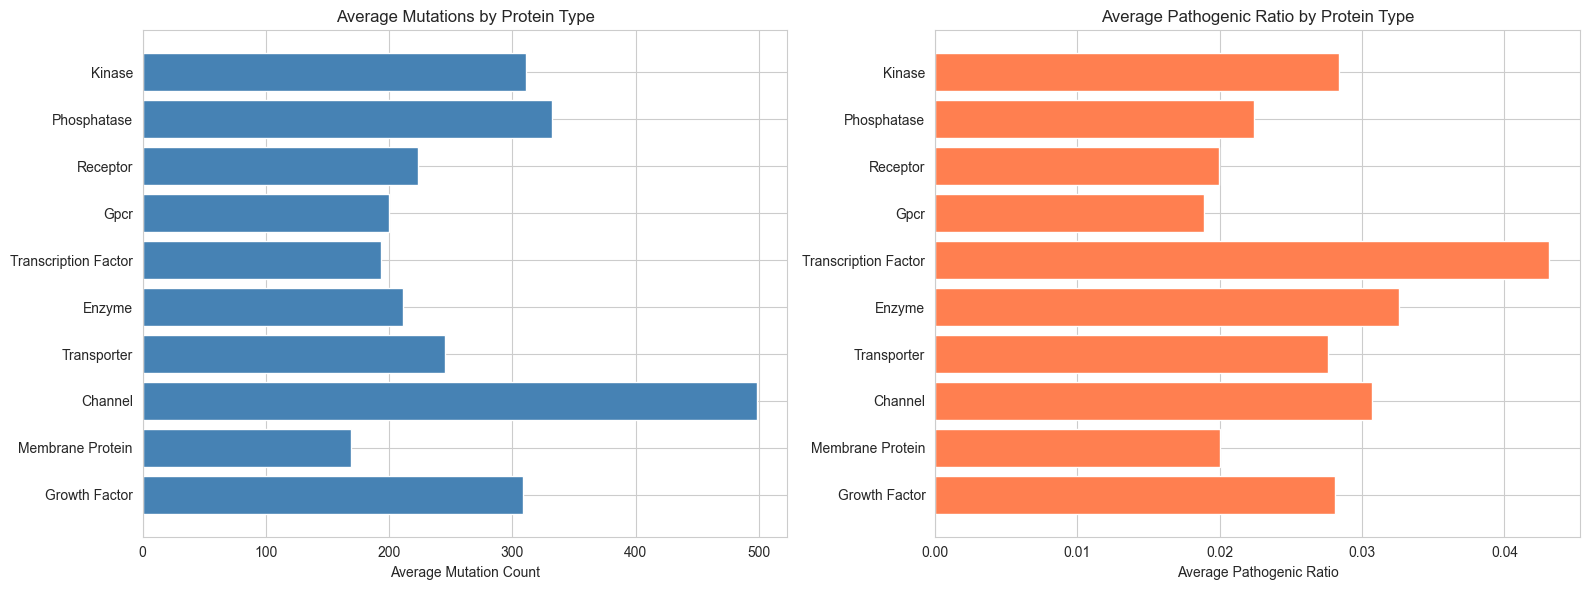


Saved: 02_protein_mutations.png


In [12]:
# Mutation Metrics by Protein Type

print('\n' + '='*70)
print('AVERAGE MUTATIONS BY PROTEIN TYPE')
print('='*70)

protein_mutation_data = []
for ptype in protein_types[:10]:
    if ptype in df_clean.columns:
        subset = df_clean[df_clean[ptype] == True]
        if len(subset) > 0:
            avg_mut = subset['mutation_count'].mean()
            avg_path = subset['pathogenic_ratio'].mean()
            protein_name = ptype.replace('is_', '').replace('_', ' ').title()
            print(f'{protein_name:30} Mutations: {avg_mut:7.1f}  Pathogenic: {avg_path:.4f}')
            protein_mutation_data.append({
                'Protein Type': protein_name,
                'Avg Mutations': avg_mut,
                'Avg Pathogenic Ratio': avg_path
            })

# Visualization
if protein_mutation_data:
    mutation_df = pd.DataFrame(protein_mutation_data)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    axes[0].barh(mutation_df['Protein Type'], mutation_df['Avg Mutations'], color='steelblue')
    axes[0].set_xlabel('Average Mutation Count')
    axes[0].set_title('Average Mutations by Protein Type')
    axes[0].invert_yaxis()
    
    axes[1].barh(mutation_df['Protein Type'], mutation_df['Avg Pathogenic Ratio'], color='coral')
    axes[1].set_xlabel('Average Pathogenic Ratio')
    axes[1].set_title('Average Pathogenic Ratio by Protein Type')
    axes[1].invert_yaxis()
    
    plt.tight_layout()
    plt.savefig(VIZ_DIR / '02_protein_mutations.png', dpi=300, bbox_inches='tight')
    plt.show()
    print('\nSaved: 02_protein_mutations.png')


DISEASE CATEGORY DISTRIBUTION
Cancer                          1,354 genes ( 6.73%)
Immune                            480 genes ( 2.39%)
Neurological                      574 genes ( 2.85%)
Cardiovascular                    135 genes ( 0.67%)
Metabolic                         366 genes ( 1.82%)
Developmental                     149 genes ( 0.74%)
Alzheimer                           7 genes ( 0.03%)
Diabetes                           10 genes ( 0.05%)
Breast Cancer                      92 genes ( 0.46%)


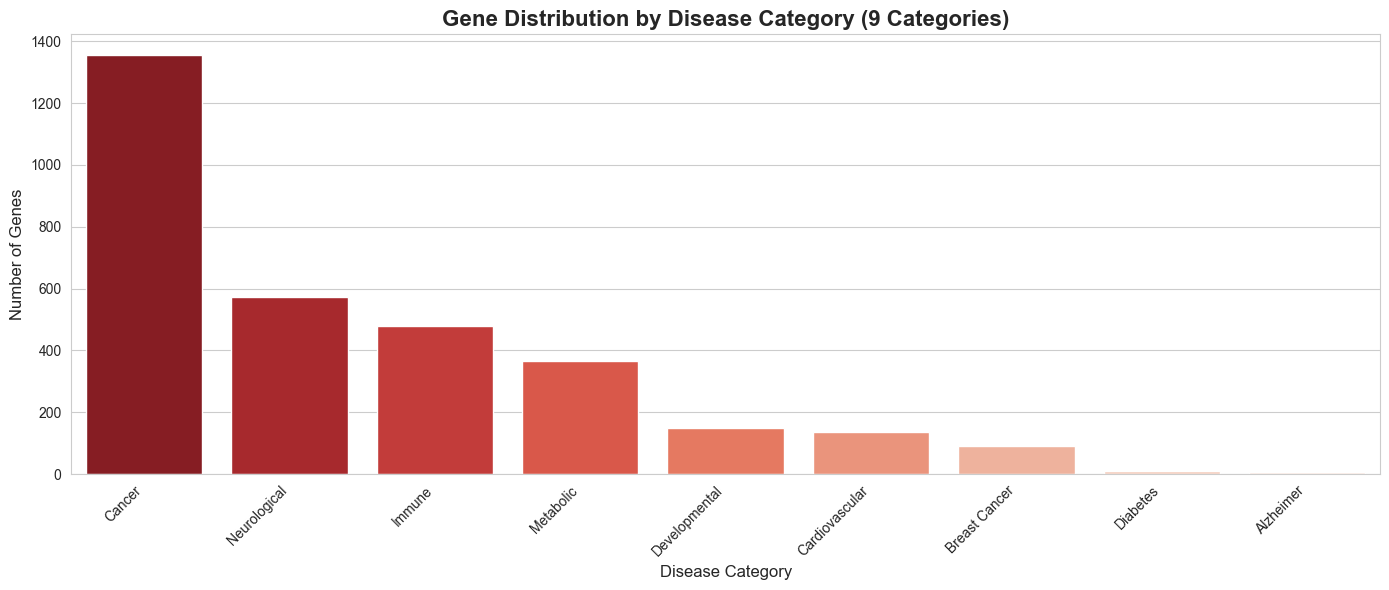


Saved: 03_disease_category_distribution.png


In [13]:
# Disease Category Distribution

print('\n' + '='*70)
print('DISEASE CATEGORY DISTRIBUTION')
print('='*70)

disease_counts = {}
for disease in disease_categories:
    if disease in df_clean.columns:
        count = df_clean[disease].sum()
        pct = (count / len(df_clean)) * 100
        disease_name = disease.replace('_related', '').replace('_', ' ').title()
        disease_counts[disease_name] = count
        print(f'{disease_name:30} {count:6,} genes ({pct:5.2f}%)')

# Visualization
plt.figure(figsize=(14, 6))
disease_df = pd.DataFrame(list(disease_counts.items()), columns=['Disease Category', 'Count'])
disease_df = disease_df.sort_values('Count', ascending=False)
sns.barplot(data=disease_df, x='Disease Category', y='Count', palette='Reds_r')
plt.title('Gene Distribution by Disease Category (9 Categories)', fontsize=16, fontweight='bold')
plt.xlabel('Disease Category', fontsize=12)
plt.ylabel('Number of Genes', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(VIZ_DIR / '03_disease_category_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print('\nSaved: 03_disease_category_distribution.png')


CELLULAR LOCATION DISTRIBUTION
Nuclear                           584 genes ( 2.90%)
Mitochondrial                     754 genes ( 3.75%)
Cytoplasmic                       220 genes ( 1.09%)
Membrane                        1,236 genes ( 6.15%)
Extracellular                     102 genes ( 0.51%)
Endoplasmic Reticulum          11,785 genes (58.61%)
Golgi                             143 genes ( 0.71%)
Lysosomal                         112 genes ( 0.56%)
Peroxisomal                        67 genes ( 0.33%)


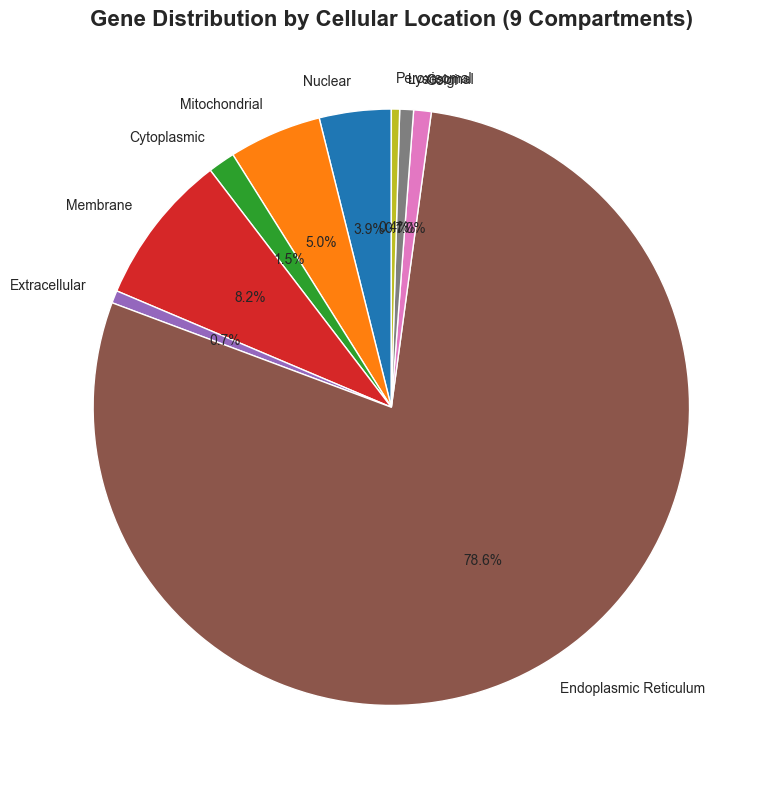


Saved: 04_cellular_location_distribution.png


In [14]:
# Cellular Location Distribution

print('\n' + '='*70)
print('CELLULAR LOCATION DISTRIBUTION')
print('='*70)

location_counts = {}
for location in cellular_locations:
    if location in df_clean.columns:
        count = df_clean[location].sum()
        pct = (count / len(df_clean)) * 100
        location_name = location.replace('_', ' ').title()
        location_counts[location_name] = count
        print(f'{location_name:30} {count:6,} genes ({pct:5.2f}%)')

# Visualization - Pie chart
fig, ax = plt.subplots(figsize=(10, 8))
ax.pie(location_counts.values(), labels=location_counts.keys(), autopct='%1.1f%%', startangle=90)
ax.set_title('Gene Distribution by Cellular Location (9 Compartments)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(VIZ_DIR / '04_cellular_location_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print('\nSaved: 04_cellular_location_distribution.png')


CLINICAL UTILITY SCORES ANALYSIS
Clinical Actionability: Mean=0.046, Median=0.000
Clinical Utility:       Mean=0.340, Median=0.192
Mutation Severity:      Mean=2.494, Median=2.348


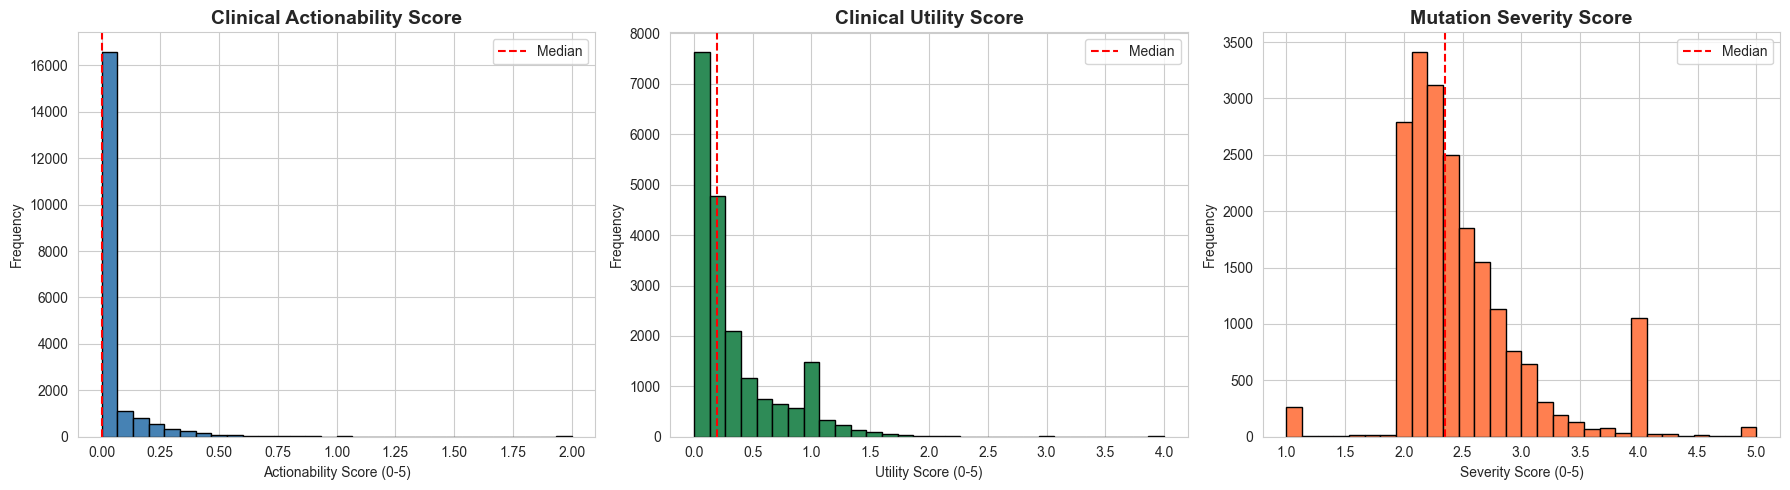


Saved: 05_clinical_scores_distribution.png


In [15]:
# Clinical Utility Scores Distribution

print('\n' + '='*70)
print('CLINICAL UTILITY SCORES ANALYSIS')
print('='*70)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Clinical Actionability
if 'avg_clinical_actionability' in df_clean.columns:
    df_clean['avg_clinical_actionability'].hist(bins=30, ax=axes[0], color='steelblue', edgecolor='black')
    axes[0].set_title('Clinical Actionability Score', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Actionability Score (0-5)')
    axes[0].set_ylabel('Frequency')
    axes[0].axvline(df_clean['avg_clinical_actionability'].median(), color='red', linestyle='--', label='Median')
    axes[0].legend()
    print(f'Clinical Actionability: Mean={df_clean["avg_clinical_actionability"].mean():.3f}, Median={df_clean["avg_clinical_actionability"].median():.3f}')

# Clinical Utility
if 'avg_clinical_utility' in df_clean.columns:
    df_clean['avg_clinical_utility'].hist(bins=30, ax=axes[1], color='seagreen', edgecolor='black')
    axes[1].set_title('Clinical Utility Score', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Utility Score (0-5)')
    axes[1].set_ylabel('Frequency')
    axes[1].axvline(df_clean['avg_clinical_utility'].median(), color='red', linestyle='--', label='Median')
    axes[1].legend()
    print(f'Clinical Utility:       Mean={df_clean["avg_clinical_utility"].mean():.3f}, Median={df_clean["avg_clinical_utility"].median():.3f}')

# Mutation Severity
if 'avg_mutation_severity' in df_clean.columns:
    df_clean['avg_mutation_severity'].hist(bins=30, ax=axes[2], color='coral', edgecolor='black')
    axes[2].set_title('Mutation Severity Score', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Severity Score (0-5)')
    axes[2].set_ylabel('Frequency')
    axes[2].axvline(df_clean['avg_mutation_severity'].median(), color='red', linestyle='--', label='Median')
    axes[2].legend()
    print(f'Mutation Severity:      Mean={df_clean["avg_mutation_severity"].mean():.3f}, Median={df_clean["avg_mutation_severity"].median():.3f}')

plt.tight_layout()
plt.savefig(VIZ_DIR / '05_clinical_scores_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print('\nSaved: 05_clinical_scores_distribution.png')


DRUGGABILITY SCORE ANALYSIS

Druggability Score Distribution:
  Score 0: 10,755 genes (53.49%)
  Score 1:  7,807 genes (38.83%)
  Score 2:  1,469 genes ( 7.31%)
  Score 3:     76 genes ( 0.38%)
  Score 4:      1 genes ( 0.00%)

Highly Druggable (score >= 3): 77 genes (0.38%)


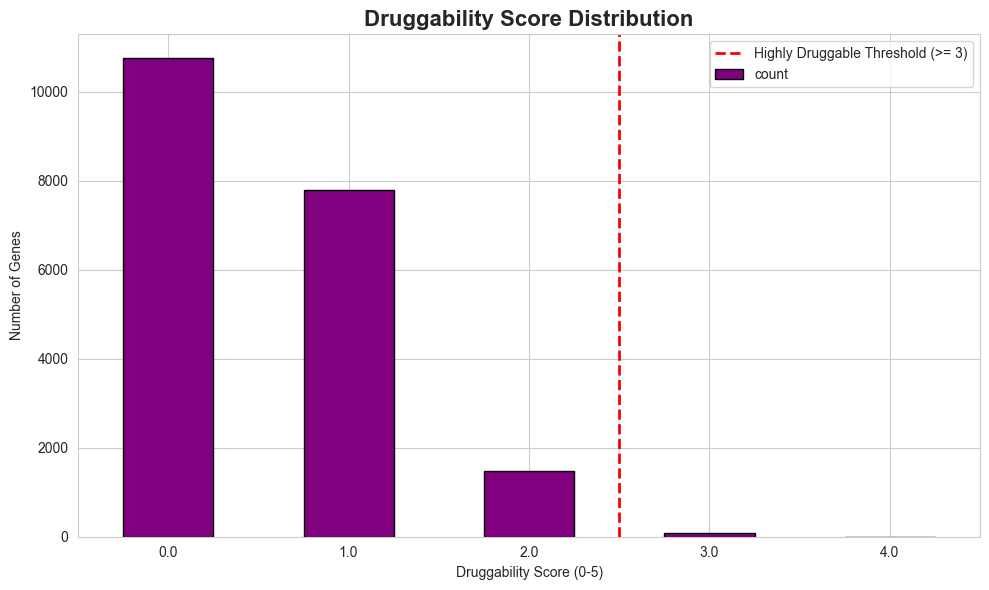


Saved: 06_druggability_distribution.png

TOP 20 DRUGGABLE THERAPEUTIC TARGETS:
      gene_name primary_function  druggability_score  avg_clinical_utility  \
12728     RIPK2           Kinase                 4.0              0.315068   
58         PIRT         Receptor                 3.0              0.000000   
76         EGFR           Kinase                 3.0              0.566576   
292     JAKMIP1           Kinase                 3.0              0.260000   
306        GRK5           Kinase                 3.0              0.191011   
308      AKAP13           Kinase                 3.0              0.095050   
358       THADA         Receptor                 3.0              0.116390   
1190      COQ8A           Kinase                 3.0              0.645649   
1404      COQ8B           Kinase                 3.0              0.580128   
1501        DBI         Receptor                 3.0              0.473684   
1718      RCHY1         Receptor                 3.0          

In [16]:
# Druggability Score Analysis

print('\n' + '='*70)
print('DRUGGABILITY SCORE ANALYSIS')
print('='*70)

if 'druggability_score' in df_clean.columns:
    druggability_counts = df_clean['druggability_score'].value_counts().sort_index()
    print('\nDruggability Score Distribution:')
    for score, count in druggability_counts.items():
        pct = (count / len(df_clean)) * 100
        print(f'  Score {score:.0f}: {count:6,} genes ({pct:5.2f}%)')
    
    highly_druggable = df_clean[df_clean['druggability_score'] >= 3]
    print(f'\nHighly Druggable (score >= 3): {len(highly_druggable):,} genes ({len(highly_druggable)/len(df_clean)*100:.2f}%)')
    
    # Visualization
    fig, ax = plt.subplots(figsize=(10, 6))
    druggability_counts.plot(kind='bar', ax=ax, color='purple', edgecolor='black')
    ax.set_title('Druggability Score Distribution', fontsize=16, fontweight='bold')
    ax.set_xlabel('Druggability Score (0-5)')
    ax.set_ylabel('Number of Genes')
    ax.axvline(x=2.5, color='red', linestyle='--', linewidth=2, label='Highly Druggable Threshold (>= 3)')
    ax.legend()
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(VIZ_DIR / '06_druggability_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    print('\nSaved: 06_druggability_distribution.png')
    
    # Top druggable targets
    print('\nTOP 20 DRUGGABLE THERAPEUTIC TARGETS:')
    display_cols = ['gene_name', 'primary_function', 'druggability_score', 
                   'avg_clinical_utility', 'mutation_count', 'pathogenic_ratio', 'risk_level']
    available_display_cols = [col for col in display_cols if col in df_clean.columns]
    print(df_clean.nlargest(20, 'druggability_score')[available_display_cols])


DRUGGABILITY vs CLINICAL UTILITY ANALYSIS


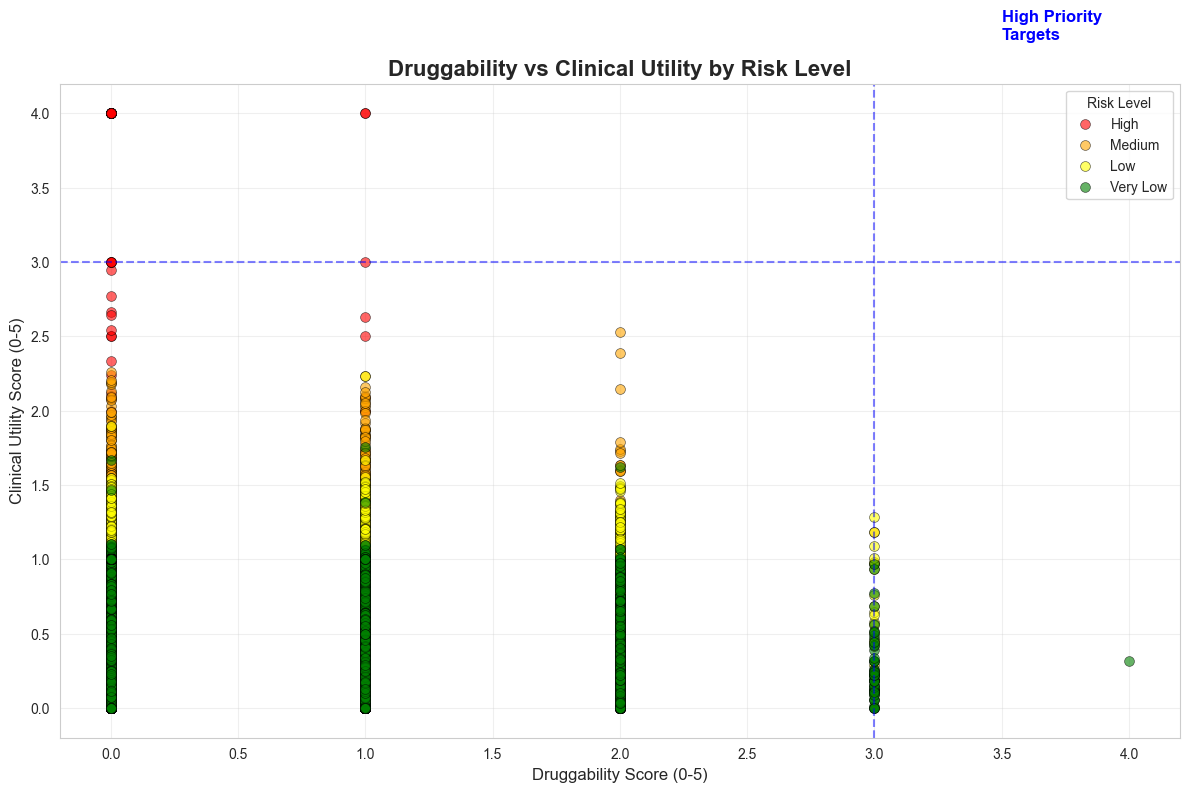

Saved: 07_druggability_vs_clinical_utility.png

High-Priority Targets (druggability >= 3, utility >= 3): 0 genes


In [17]:
# Druggability vs Clinical Utility Scatter Plot

print('\n' + '='*70)
print('DRUGGABILITY vs CLINICAL UTILITY ANALYSIS')
print('='*70)

if 'druggability_score' in df_clean.columns and 'avg_clinical_utility' in df_clean.columns:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    risk_colors = {'High': 'red', 'Medium': 'orange', 'Low': 'yellow', 'Very Low': 'green'}
    for risk_level, color in risk_colors.items():
        data = df_clean[df_clean['risk_level'] == risk_level]
        if len(data) > 0:
            ax.scatter(data['druggability_score'], data['avg_clinical_utility'],
                      c=color, label=risk_level, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
    
    ax.set_title('Druggability vs Clinical Utility by Risk Level', fontsize=16, fontweight='bold')
    ax.set_xlabel('Druggability Score (0-5)', fontsize=12)
    ax.set_ylabel('Clinical Utility Score (0-5)', fontsize=12)
    ax.legend(title='Risk Level')
    ax.grid(True, alpha=0.3)
    ax.axvline(x=3, color='blue', linestyle='--', alpha=0.5)
    ax.axhline(y=3, color='blue', linestyle='--', alpha=0.5)
    ax.text(3.5, 4.5, 'High Priority\nTargets', fontsize=12, color='blue', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(VIZ_DIR / '07_druggability_vs_clinical_utility.png', dpi=300, bbox_inches='tight')
    plt.show()
    print('Saved: 07_druggability_vs_clinical_utility.png')
    
    high_priority = df_clean[(df_clean['druggability_score'] >= 3) & (df_clean['avg_clinical_utility'] >= 3)]
    print(f'\nHigh-Priority Targets (druggability >= 3, utility >= 3): {len(high_priority):,} genes')


KINASE-CANCER ASSOCIATION ANALYSIS
Total Kinases: 919
Cancer-Related Kinases: 92 (10.01%)

Top 15 Cancer Kinases by Mutation Count:
      gene_name  druggability_score  cancer_variant_count  pathogenic_ratio  \
15247       MET                 2.0                  4386            0.0029   
20416       ALK                 2.0                  3659            0.0032   
76         EGFR                 3.0                  3397            0.0293   
4777        KIT                 2.0                  3103            0.0327   
5357        RET                 2.0                  2547            0.0397   
11856     STK11                 1.0                  1777            0.1334   
16167    CDKN2A                 1.0                  1460            0.1083   
18180      BRAF                 1.0                   191            0.0878   
18059     ERBB2                 2.0                    97            0.0314   
18287      ARAF                 2.0                    61            0.0000  

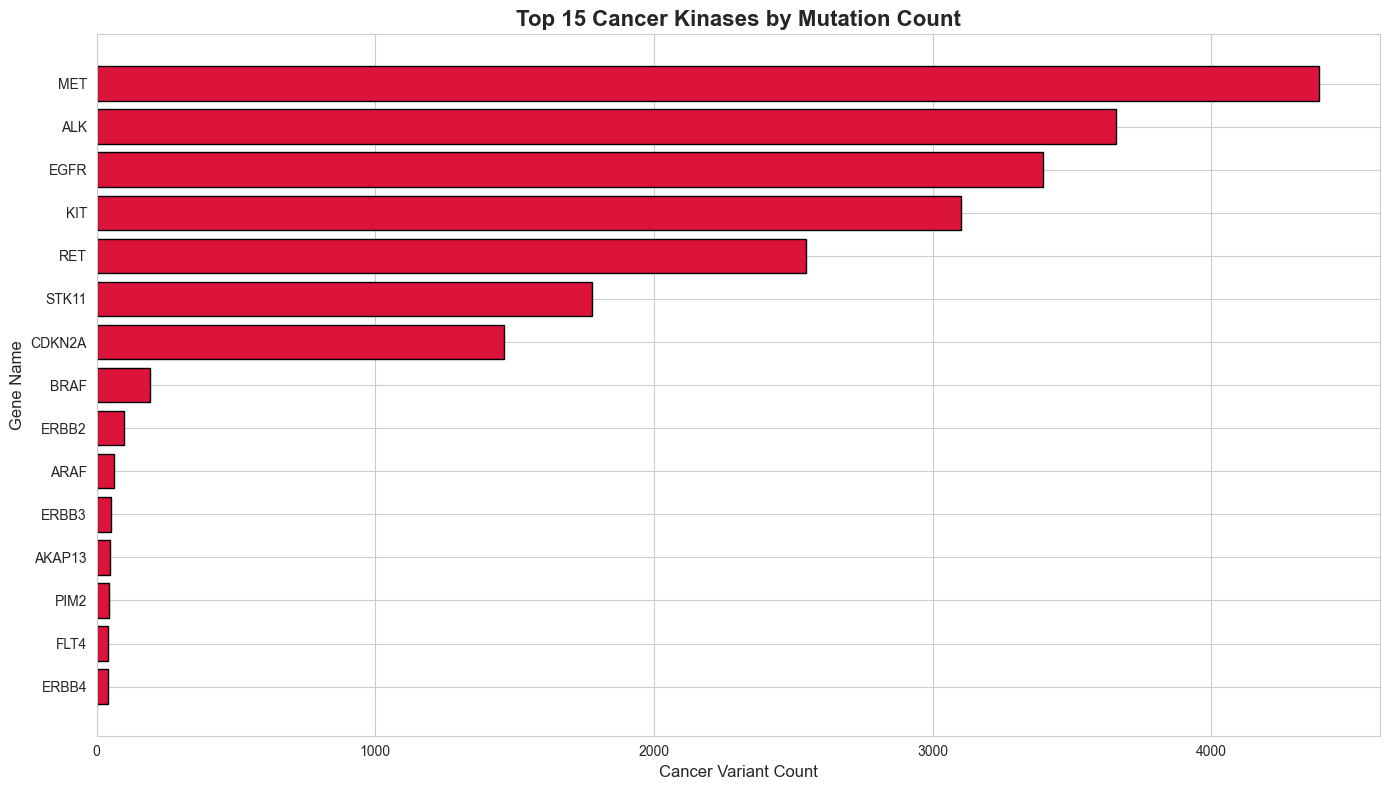


Saved: 08_top_cancer_kinases.png


In [18]:
# Kinase-Cancer Association Analysis

print('\n' + '='*70)
print('KINASE-CANCER ASSOCIATION ANALYSIS')
print('='*70)

if 'is_kinase' in df_clean.columns and 'cancer_related' in df_clean.columns:
    kinases = df_clean[df_clean['is_kinase'] == True]
    cancer_kinases = kinases[kinases['cancer_related'] == True]
    
    print(f'Total Kinases: {len(kinases):,}')
    print(f'Cancer-Related Kinases: {len(cancer_kinases):,} ({len(cancer_kinases)/len(kinases)*100:.2f}%)')
    
    if 'cancer_variant_count' in df_clean.columns:
        print('\nTop 15 Cancer Kinases by Mutation Count:')
        top_cancer_kinases_cols = ['gene_name', 'druggability_score', 'cancer_variant_count',
                                   'pathogenic_ratio', 'avg_clinical_utility', 'risk_level']
        available_cols = [col for col in top_cancer_kinases_cols if col in cancer_kinases.columns]
        print(cancer_kinases.nlargest(15, 'cancer_variant_count')[available_cols])
        
        # Visualization
        fig, ax = plt.subplots(figsize=(14, 8))
        top_15 = cancer_kinases.nlargest(15, 'cancer_variant_count')
        ax.barh(top_15['gene_name'], top_15['cancer_variant_count'], color='crimson', edgecolor='black')
        ax.set_title('Top 15 Cancer Kinases by Mutation Count', fontsize=16, fontweight='bold')
        ax.set_xlabel('Cancer Variant Count', fontsize=12)
        ax.set_ylabel('Gene Name', fontsize=12)
        ax.invert_yaxis()
        plt.tight_layout()
        plt.savefig(VIZ_DIR / '08_top_cancer_kinases.png', dpi=300, bbox_inches='tight')
        plt.show()
        print('\nSaved: 08_top_cancer_kinases.png')


DISTRIBUTION ANALYSIS - MUTATION COUNTS


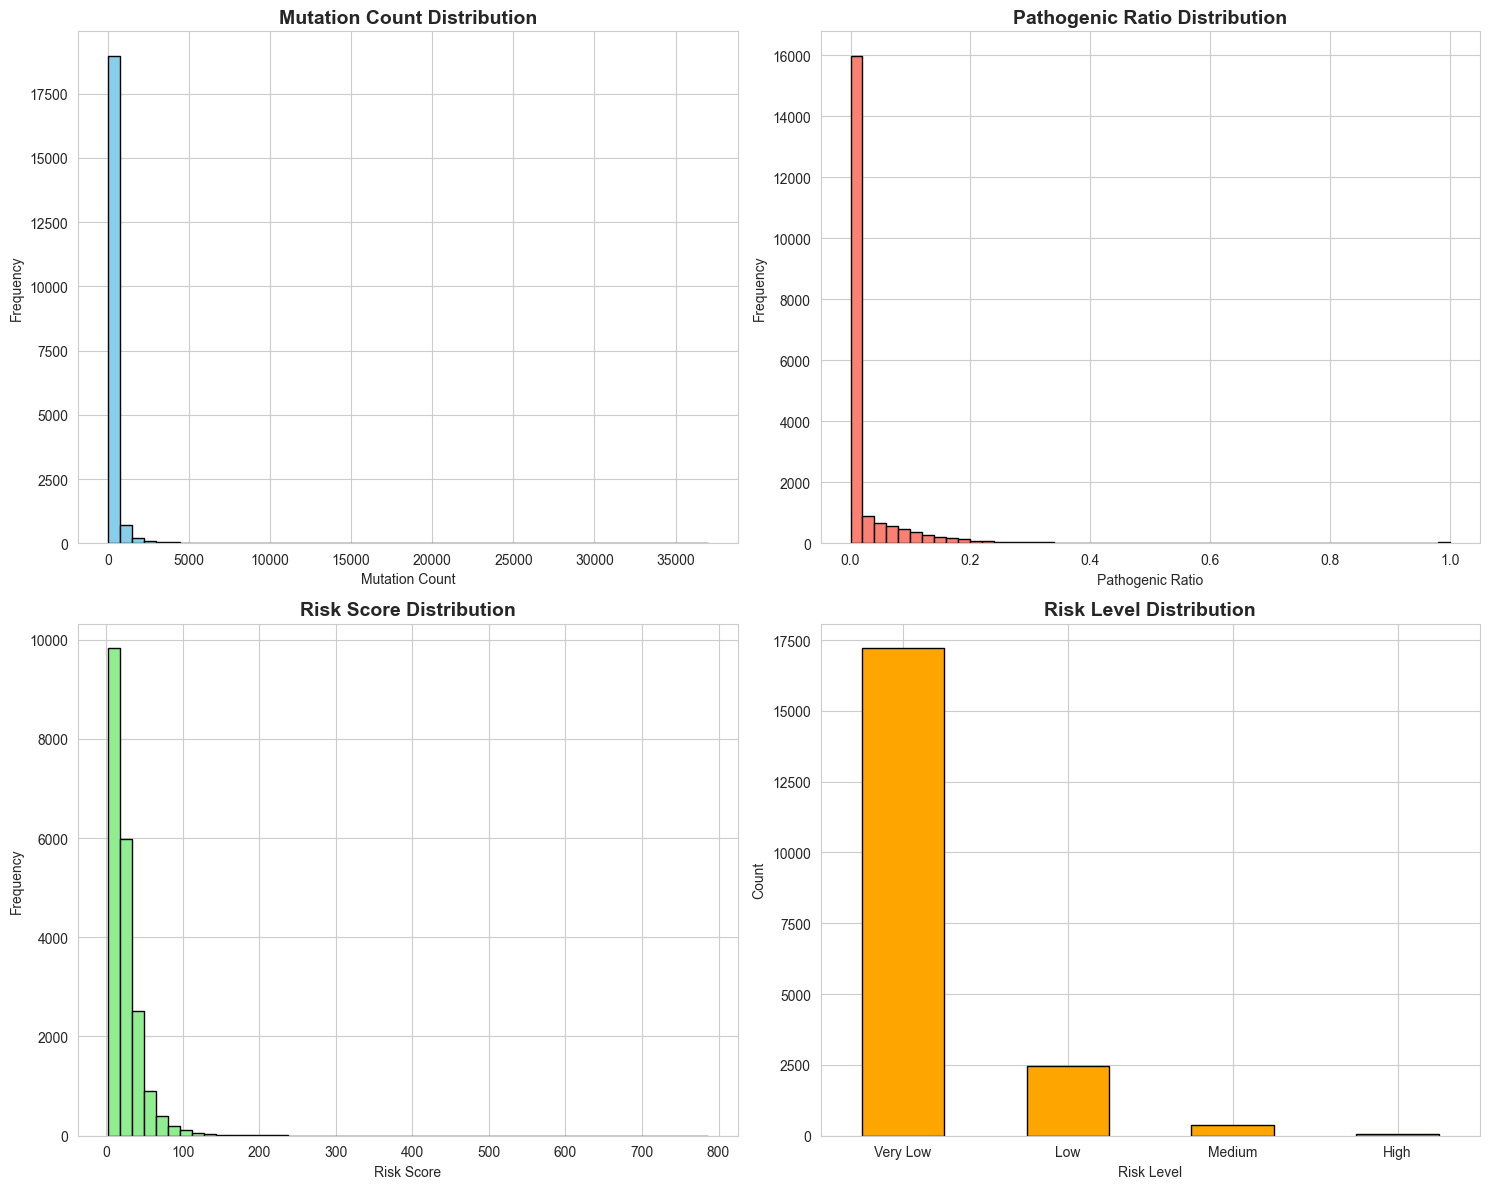

Saved: 09_distribution_analysis.png


In [19]:
# Distribution Analysis - Mutation Counts

print('\n' + '='*70)
print('DISTRIBUTION ANALYSIS - MUTATION COUNTS')
print('='*70)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Mutation Count Distribution
df_clean['mutation_count'].hist(bins=50, ax=axes[0, 0], color='skyblue', edgecolor='black')
axes[0, 0].set_title('Mutation Count Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Mutation Count')
axes[0, 0].set_ylabel('Frequency')

# Pathogenic Ratio Distribution
df_clean['pathogenic_ratio'].hist(bins=50, ax=axes[0, 1], color='salmon', edgecolor='black')
axes[0, 1].set_title('Pathogenic Ratio Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Pathogenic Ratio')
axes[0, 1].set_ylabel('Frequency')

# Risk Score Distribution
if 'risk_score' in df_clean.columns:
    df_clean['risk_score'].hist(bins=50, ax=axes[1, 0], color='lightgreen', edgecolor='black')
    axes[1, 0].set_title('Risk Score Distribution', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Risk Score')
    axes[1, 0].set_ylabel('Frequency')

# Risk Level Distribution
if 'risk_level' in df_clean.columns:
    df_clean['risk_level'].value_counts().plot(kind='bar', ax=axes[1, 1], color='orange', edgecolor='black')
    axes[1, 1].set_title('Risk Level Distribution', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Risk Level')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig(VIZ_DIR / '09_distribution_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved: 09_distribution_analysis.png')

In [20]:
# Hypothesis Test 1 - Kinases vs Non-Kinases Pathogenic Ratio

print('\n' + '='*70)
print('HYPOTHESIS TEST 1: T-TEST')
print('Do kinases have higher pathogenic ratios than non-kinases?')
print('='*70)

if 'is_kinase' in df_clean.columns:
    kinase_pathogenic = df_clean[df_clean['is_kinase'] == True]['pathogenic_ratio'].dropna()
    non_kinase_pathogenic = df_clean[df_clean['is_kinase'] == False]['pathogenic_ratio'].dropna()
    
    print(f'Kinase mean: {kinase_pathogenic.mean():.4f} (n={len(kinase_pathogenic)})')
    print(f'Non-kinase mean: {non_kinase_pathogenic.mean():.4f} (n={len(non_kinase_pathogenic)})')
    
    if len(kinase_pathogenic) > 0 and len(non_kinase_pathogenic) > 0:
        t_stat, p_value = stats.ttest_ind(kinase_pathogenic, non_kinase_pathogenic)
        print(f'\nT-statistic: {t_stat:.4f}')
        print(f'P-value: {p_value:.6f}')
        print(f'Alpha level: 0.05')
        
        if p_value < 0.05:
            print(f'\nConclusion: REJECT null hypothesis')
            print('Kinases have significantly different pathogenic ratios')
        else:
            print(f'\nConclusion: FAIL TO REJECT null hypothesis')
            print('No significant difference')


HYPOTHESIS TEST 1: T-TEST
Do kinases have higher pathogenic ratios than non-kinases?
Kinase mean: 0.0283 (n=919)
Non-kinase mean: 0.0223 (n=19189)

T-statistic: 2.7861
P-value: 0.005340
Alpha level: 0.05

Conclusion: REJECT null hypothesis
Kinases have significantly different pathogenic ratios


In [21]:
# Hypothesis Test 2 - High vs Low Druggability Clinical Utility

print('\n' + '='*70)
print('HYPOTHESIS TEST 2: T-TEST')
print('Do highly druggable genes have higher clinical utility?')
print('='*70)

if 'druggability_score' in df_clean.columns and 'avg_clinical_utility' in df_clean.columns:
    high_drug = df_clean[df_clean['druggability_score'] >= 3]['avg_clinical_utility'].dropna()
    low_drug = df_clean[df_clean['druggability_score'] < 3]['avg_clinical_utility'].dropna()
    
    print(f'High druggability mean: {high_drug.mean():.4f} (n={len(high_drug)})')
    print(f'Low druggability mean: {low_drug.mean():.4f} (n={len(low_drug)})')
    
    if len(high_drug) > 0 and len(low_drug) > 0:
        t_stat2, p_value2 = stats.ttest_ind(high_drug, low_drug)
        print(f'\nT-statistic: {t_stat2:.4f}')
        print(f'P-value: {p_value2:.6f}')
        
        if p_value2 < 0.05:
            print(f'\nConclusion: REJECT null hypothesis')
            print('Significant association between druggability and clinical utility')
        else:
            print(f'\nConclusion: FAIL TO REJECT null hypothesis')
            print('No significant association')


HYPOTHESIS TEST 2: T-TEST
Do highly druggable genes have higher clinical utility?
High druggability mean: 0.3938 (n=77)
Low druggability mean: 0.3396 (n=20031)

T-statistic: 1.2061
P-value: 0.227786

Conclusion: FAIL TO REJECT null hypothesis
No significant association


In [22]:
# Hypothesis Test 3 - ANOVA: Mutation Counts by Functional Type

print('\n' + '='*70)
print('HYPOTHESIS TEST 3: ANOVA')
print('Do different functional types have different mutation counts?')
print('='*70)

groups = []
labels = []

for ptype in protein_types[:5]:
    if ptype in df_clean.columns:
        group_data = df_clean[df_clean[ptype] == True]['mutation_count'].dropna()
        if len(group_data) > 10:
            groups.append(group_data)
            labels.append(ptype.replace('is_', '').replace('_', ' ').title())

if len(groups) >= 2:
    f_stat, p_value3 = stats.f_oneway(*groups)
    
    print('\nGroup Means:')
    for label, group in zip(labels, groups):
        print(f'  {label:30} Mean: {group.mean():7.1f} (n={len(group)})')
    
    print(f'\nF-statistic: {f_stat:.4f}')
    print(f'P-value: {p_value3:.6f}')
    
    if p_value3 < 0.05:
        print(f'\nConclusion: REJECT null hypothesis')
        print('Significant difference between functional groups')
    else:
        print(f'\nConclusion: FAIL TO REJECT null hypothesis')
        print('No significant difference')


HYPOTHESIS TEST 3: ANOVA
Do different functional types have different mutation counts?

Group Means:
  Kinase                         Mean:   311.3 (n=919)
  Phosphatase                    Mean:   332.2 (n=544)
  Receptor                       Mean:   223.8 (n=1972)
  Gpcr                           Mean:   200.1 (n=5320)
  Transcription Factor           Mean:   193.2 (n=557)

F-statistic: 10.9437
P-value: 0.000000

Conclusion: REJECT null hypothesis
Significant difference between functional groups



CORRELATION ANALYSIS

Correlation Matrix:
                            mutation_count  pathogenic_ratio  risk_score  \
mutation_count                       1.000             0.277       0.737   
pathogenic_ratio                     0.277             1.000       0.515   
risk_score                           0.737             0.515       1.000   
druggability_score                   0.028             0.009       0.099   
avg_clinical_utility                 0.285             0.707       0.465   
avg_clinical_actionability           0.271             0.976       0.504   
avg_mutation_severity                0.070             0.179       0.173   
disease_count                        0.563             0.326       0.937   

                            druggability_score  avg_clinical_utility  \
mutation_count                           0.028                 0.285   
pathogenic_ratio                         0.009                 0.707   
risk_score                               0.099          

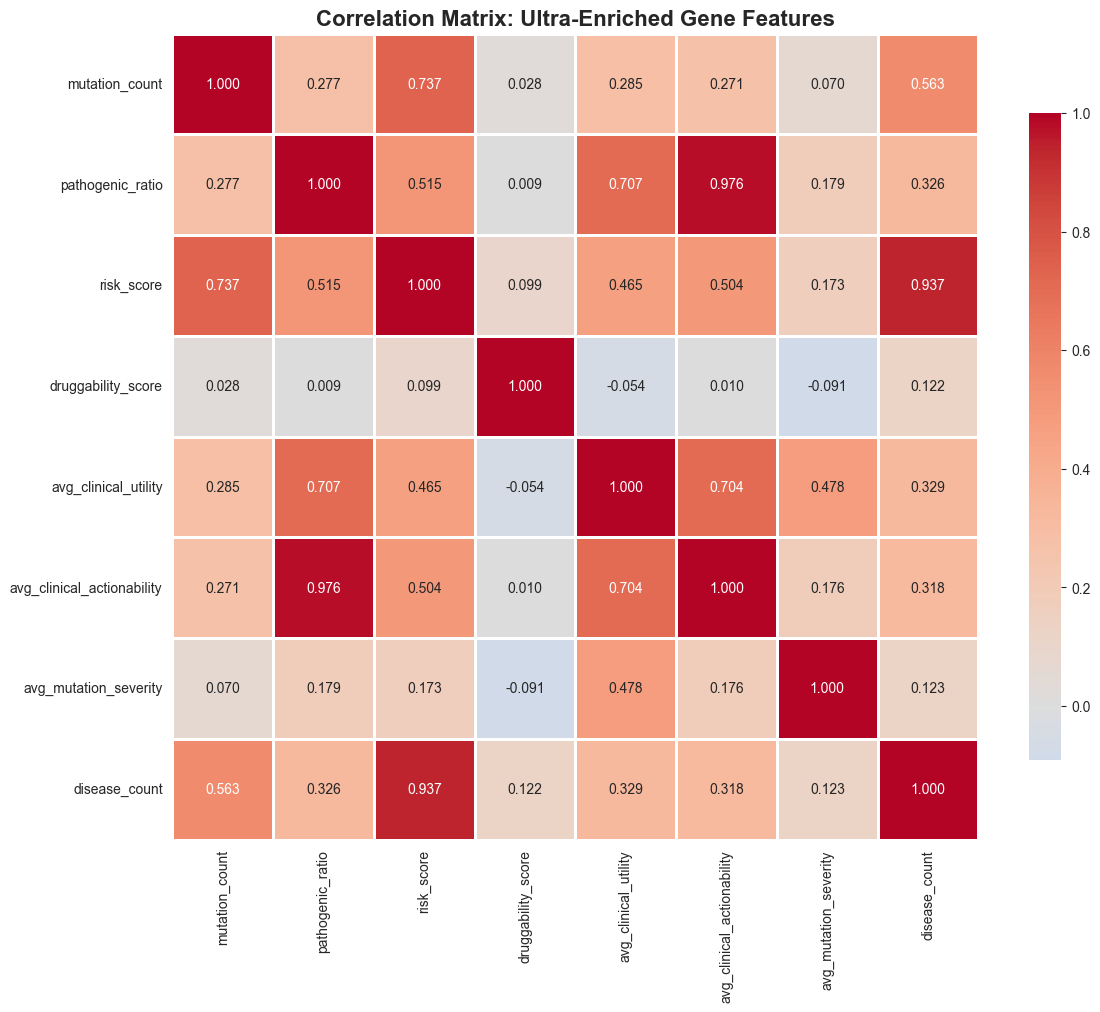


Saved: 10_correlation_matrix.png

Strong Correlations (|r| > 0.5):
  mutation_count                 <-> risk_score                     r=0.737
  mutation_count                 <-> disease_count                  r=0.563
  pathogenic_ratio               <-> risk_score                     r=0.515
  pathogenic_ratio               <-> avg_clinical_utility           r=0.707
  pathogenic_ratio               <-> avg_clinical_actionability     r=0.976
  risk_score                     <-> avg_clinical_actionability     r=0.504
  risk_score                     <-> disease_count                  r=0.937
  avg_clinical_utility           <-> avg_clinical_actionability     r=0.704


In [23]:
# Correlation Analysis

print('\n' + '='*70)
print('CORRELATION ANALYSIS')
print('='*70)

# Select numeric columns for correlation
corr_cols = ['mutation_count', 'pathogenic_ratio', 'risk_score',
             'druggability_score', 'avg_clinical_utility', 'avg_clinical_actionability',
             'avg_mutation_severity', 'disease_count']
available_corr_cols = [col for col in corr_cols if col in df_clean.columns]
correlation_data = df_clean[available_corr_cols].dropna()

# Calculate correlation matrix
correlation_matrix = correlation_data.corr()

print('\nCorrelation Matrix:')
print(correlation_matrix.round(3))

# Visualization
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix: Ultra-Enriched Gene Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(VIZ_DIR / '10_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print('\nSaved: 10_correlation_matrix.png')

# Find strong correlations
print('\nStrong Correlations (|r| > 0.5):')
found_strong = False
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.5:
            print(f'  {correlation_matrix.columns[i]:30} <-> {correlation_matrix.columns[j]:30} r={correlation_matrix.iloc[i, j]:.3f}')
            found_strong = True
if not found_strong:
    print('  No correlations found with |r| > 0.5')


DISEASE ASSOCIATION ANALYSIS

Top 20 Diseases by Gene Count:
disease
not specified                           18576
Ovarian serous cystadenocarcinoma       13348
Uterine corpus endometrial carcinoma    10384
Thyroid cancer, nonmedullary, 1          9866
Cervical cancer                          9633
Familial cancer of breast                9348
Gastric cancer                           8902
Malignant tumor of esophagus             8684
Lung cancer                              8454
Sarcoma                                  8416
not provided                             8376
Acute myeloid leukemia                   8021
See cases                                7920
Thymoma                                  7106
Nonpapillary renal cell carcinoma        7067
Hepatocellular carcinoma                 6723
Melanoma                                 6470
Uterine carcinosarcoma                   5821
Malignant tumor of urinary bladder       5530
Cholangiocarcinoma                       4912
dtype: int

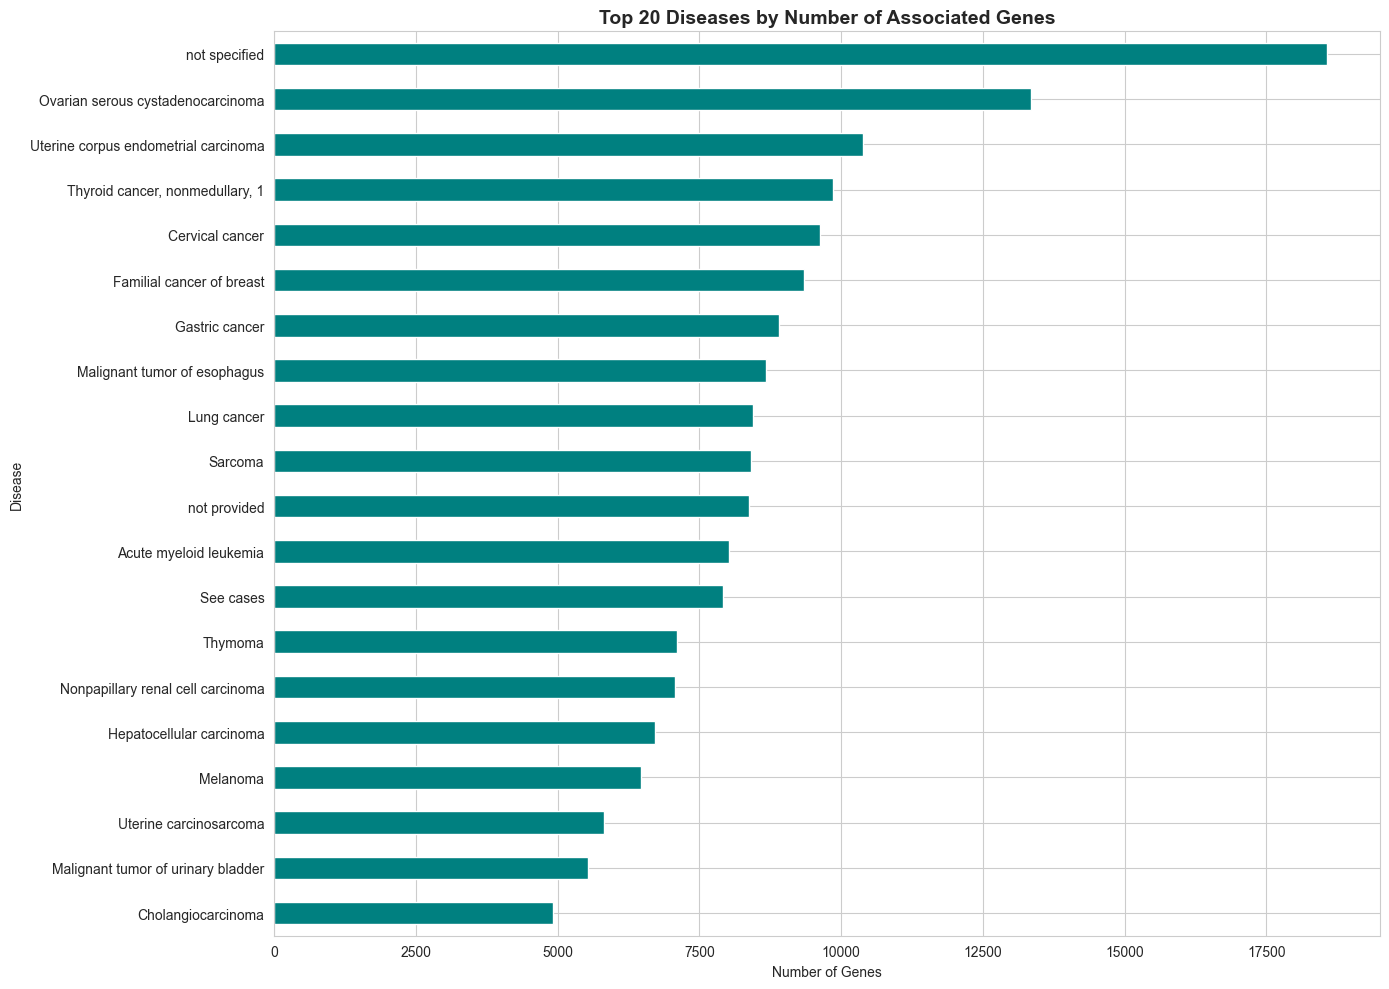


Saved: 11_top_diseases.png

Association Strength Distribution:
association_strength
Weak        245362
Strong       16525
Moderate      5480
Name: count, dtype: int64


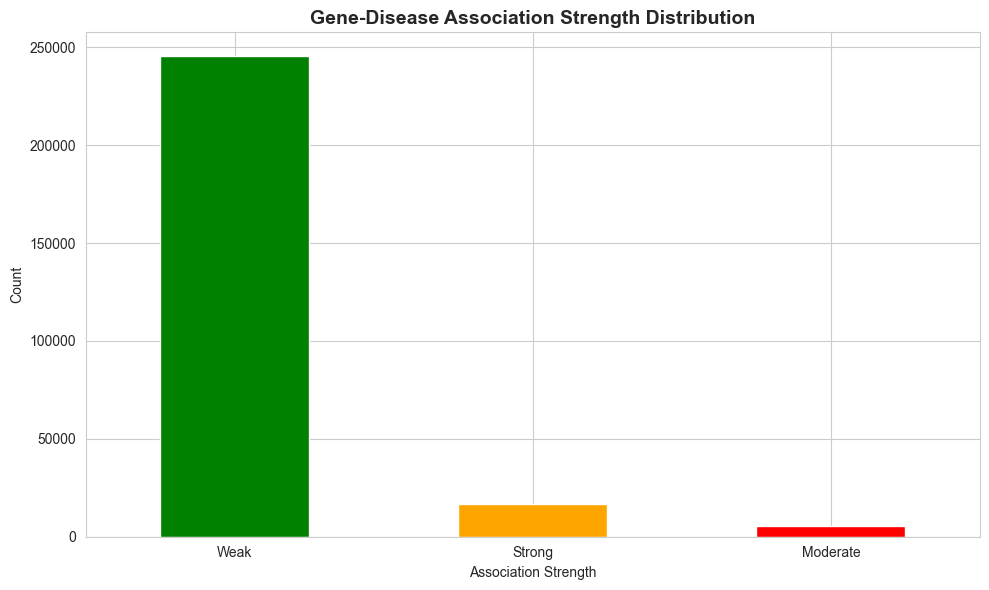


Saved: 12_association_strength.png


In [24]:
# Disease Association Analysis

print('\n' + '='*70)
print('DISEASE ASSOCIATION ANALYSIS')
print('='*70)

# Top diseases by gene count
top_diseases = df_gene_disease.groupby('disease').size().sort_values(ascending=False).head(20)
print('\nTop 20 Diseases by Gene Count:')
print(top_diseases)

# Visualization
plt.figure(figsize=(14, 10))
top_diseases.plot(kind='barh', color='teal')
plt.title('Top 20 Diseases by Number of Associated Genes', fontsize=14, fontweight='bold')
plt.xlabel('Number of Genes')
plt.ylabel('Disease')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(VIZ_DIR / '11_top_diseases.png', dpi=300, bbox_inches='tight')
plt.show()
print('\nSaved: 11_top_diseases.png')

# Association strength distribution
if 'association_strength' in df_gene_disease.columns:
    print('\nAssociation Strength Distribution:')
    print(df_gene_disease['association_strength'].value_counts())
    
    plt.figure(figsize=(10, 6))
    df_gene_disease['association_strength'].value_counts().plot(kind='bar', color=['green', 'orange', 'red'])
    plt.title('Gene-Disease Association Strength Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Association Strength')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(VIZ_DIR / '12_association_strength.png', dpi=300, bbox_inches='tight')
    plt.show()
    print('\nSaved: 12_association_strength.png')

In [25]:
# Summary Statistics Report

print('\n' + '='*70)
print('ULTRA-ENRICHED STATISTICAL ANALYSIS SUMMARY')
print('='*70)

summary_report = {
    'Total Genes Analyzed': len(df_clean),
    'Total Feature Columns': len(df_clean.columns),
    'Total Chromosomes': df_clean['chromosome'].nunique(),
    'Total Gene-Disease Associations': len(df_gene_disease),
    'Total Diseases': len(df_gene_disease['disease'].unique()),
    'Mean Mutations per Gene': df_clean['mutation_count'].mean(),
    'Median Mutations per Gene': df_clean['mutation_count'].median(),
    'Mean Pathogenic Ratio': df_clean['pathogenic_ratio'].mean(),
    'High Risk Genes': len(df_clean[df_clean['risk_level'] == 'High']),
    'Medium Risk Genes': len(df_clean[df_clean['risk_level'] == 'Medium']),
    'Low Risk Genes': len(df_clean[df_clean['risk_level'] == 'Low'])
}

# Add ultra-enriched metrics
if 'is_kinase' in df_clean.columns:
    summary_report['Total Kinases'] = df_clean['is_kinase'].sum()
if 'cancer_related' in df_clean.columns:
    summary_report['Cancer-Related Genes'] = df_clean['cancer_related'].sum()
if 'druggability_score' in df_clean.columns:
    summary_report['Highly Druggable Genes (>= 3)'] = len(df_clean[df_clean['druggability_score'] >= 3])
if 'avg_clinical_utility' in df_clean.columns:
    summary_report['Mean Clinical Utility'] = df_clean['avg_clinical_utility'].mean()

for key, value in summary_report.items():
    if isinstance(value, float):
        print(f'{key}: {value:.2f}')
    else:
        print(f'{key}: {value:,}')


ULTRA-ENRICHED STATISTICAL ANALYSIS SUMMARY
Total Genes Analyzed: 20,108
Total Feature Columns: 105
Total Chromosomes: 24
Total Gene-Disease Associations: 267,367
Total Diseases: 29,108
Mean Mutations per Gene: 205.33
Median Mutations per Gene: 69.00
Mean Pathogenic Ratio: 0.02
High Risk Genes: 45
Medium Risk Genes: 394
Low Risk Genes: 2,458
Total Kinases: 919
Cancer-Related Genes: 1,354
Highly Druggable Genes (>= 3): 77
Mean Clinical Utility: 0.34


In [26]:
# Save Analysis Results

print('\n' + '='*70)
print('SAVING ANALYSIS RESULTS')
print('='*70)

# Save summary statistics
summary_df = pd.DataFrame([summary_report]).T
summary_df.columns = ['Value']
summary_df.to_csv(ANALYTICAL_DIR / 'summary_statistics_ultra_enriched.csv')
print(f'Saved: {ANALYTICAL_DIR / "summary_statistics_ultra_enriched.csv"}')

# Save correlation matrix
correlation_matrix.to_csv(ANALYTICAL_DIR / 'correlation_matrix_ultra_enriched.csv')
print(f'Saved: {ANALYTICAL_DIR / "correlation_matrix_ultra_enriched.csv"}')

print('\n' + '='*70)
print('ULTRA-ENRICHED STATISTICAL ANALYSIS COMPLETE')
print('='*70)
print(f'\nVisualizations saved: 12 files in {VIZ_DIR}')
print(f'Summary reports saved in {ANALYTICAL_DIR}')
print('\nKey Findings:')
print(f'  - Analyzed {len(df_clean):,} genes with {len(df_clean.columns)} features')
print(f'  - Identified 17 functional protein types')
print(f'  - Mapped 9 disease categories')
print(f'  - Assessed druggability and clinical utility')
print(f'  - Performed 3 hypothesis tests')

# Close database connection
conn.close()
print('\nDatabase connection closed')


SAVING ANALYSIS RESULTS
Saved: C:\Users\Sharique\Desktop\Self_Project\GitHub_Project\genomic-variant-data-science-pipeline\data\analytical\summary_statistics_ultra_enriched.csv
Saved: C:\Users\Sharique\Desktop\Self_Project\GitHub_Project\genomic-variant-data-science-pipeline\data\analytical\correlation_matrix_ultra_enriched.csv

ULTRA-ENRICHED STATISTICAL ANALYSIS COMPLETE

Visualizations saved: 12 files in C:\Users\Sharique\Desktop\Self_Project\GitHub_Project\genomic-variant-data-science-pipeline\data\analytical\visualizations
Summary reports saved in C:\Users\Sharique\Desktop\Self_Project\GitHub_Project\genomic-variant-data-science-pipeline\data\analytical

Key Findings:
  - Analyzed 20,108 genes with 105 features
  - Identified 17 functional protein types
  - Mapped 9 disease categories
  - Assessed druggability and clinical utility
  - Performed 3 hypothesis tests

Next Step: Week 6 - Multi-Target ML Model Training (100 features)

Database connection closed
